In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("benchmark_results.csv", sep="\t")
df = df.melt(id_vars=['layers', 'T'], value_vars=['sequential', 'parallel', "parallel_optimized", 'fully_parallel', "fully_parallel_optimized"], var_name='benchmark', value_name='avg_time')

print(df.head())

   layers   T   benchmark  avg_time
0       4   8  sequential     0.323
1       4  16  sequential     0.438
2       4  32  sequential     0.681
3       6   8  sequential     0.390
4       6  16  sequential     0.534


In [3]:
import colorsys
from matplotlib.colors import hex2color, to_hex

def generate_palette(base_colors, p):
    rgb_colors = [hex2color(color) for color in base_colors]
    hls_colors = [colorsys.rgb_to_hls(*color) for color in rgb_colors]
    adjusted_hls_colors = [(h, p, s) for h, l, s in hls_colors]
    return [to_hex(colorsys.hls_to_rgb(*color)) for color in adjusted_hls_colors]

base_colors = ['#f44336', '#2196f3', '#00bcd4', '#4caf50', '#cddc39']

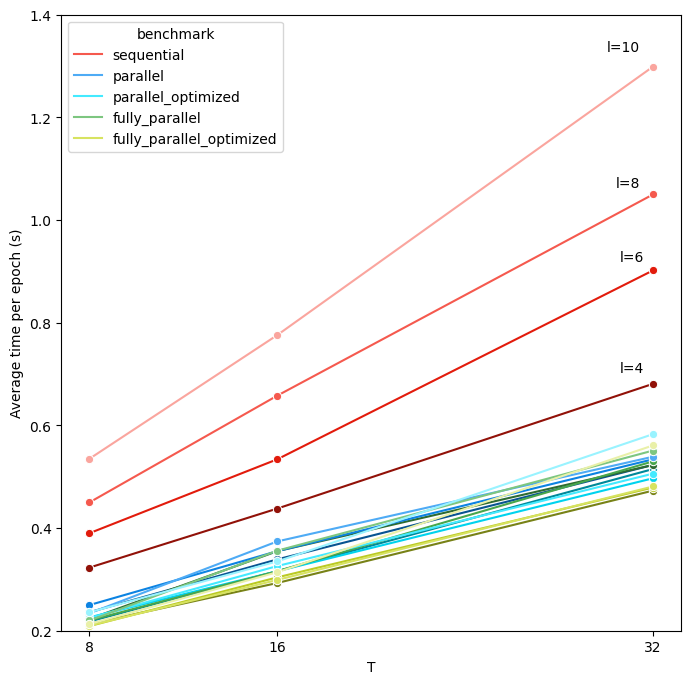

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for i, (p, l) in enumerate(zip(np.linspace(0.3, 0.8, len(df["layers"].unique())), df["layers"].unique())):
    sns.lineplot(
        data=df[df['layers'] == l],
        x='T', y='avg_time', hue='benchmark',
        marker="o",
        ax=ax,
        palette=generate_palette(base_colors, p),
        legend="full" if i == len(df["layers"].unique()) // 2 else False)
ax.text(0.9, 0.42, "L=4", transform=ax.transAxes)
ax.text(0.9, 0.60, "L=6", transform=ax.transAxes)
ax.text(0.895, 0.72, "L=8", transform=ax.transAxes)
ax.text(0.88, 0.94, "L=10", transform=ax.transAxes)

ax.set_ylim(0.2, 1.4)
ax.set_ylabel("Average time per epoch (s)")
ax.set_xticks(df["T"].unique())

plt.show()

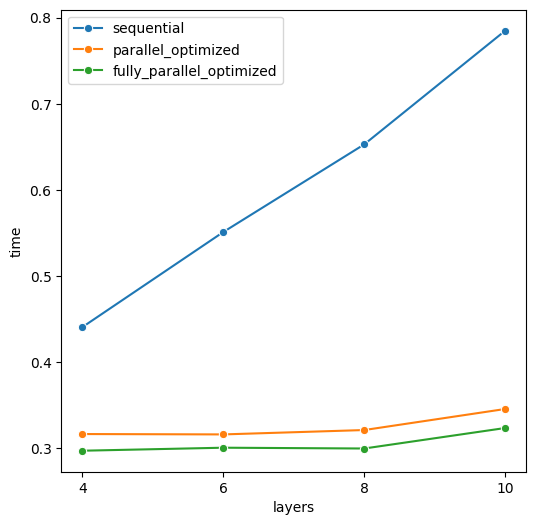

In [51]:
def compute_time(df, layers, benchmark, T):
    # Perform linear regression on the data to compute the time per epoch for a given T
    df = df[(df["layers"] == layers) & (df["benchmark"] == benchmark)][["T", "avg_time"]]

    # use scikit to perform linear regression
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression().fit(df["T"].values.reshape(-1, 1), df["avg_time"].values.reshape(-1, 1))

    # compute the time per epoch for a given T
    time = reg.predict(np.array([[T]]))[0][0]
    
    return time

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

for b in ["sequential", "parallel_optimized", "fully_parallel_optimized"]:
    datapoints = []
    for l in sorted(df["layers"].unique()):
        T = 16
        x = l
        y = compute_time(df, l, b, T)
        datapoints.append([x, y])
    
    data = pd.DataFrame(datapoints, columns=["layers", "time"])
    sns.lineplot(data=data, x="layers", y="time", marker="o", ax=ax, label=b)


ax.set_xticks(df["layers"].unique())
plt.show()

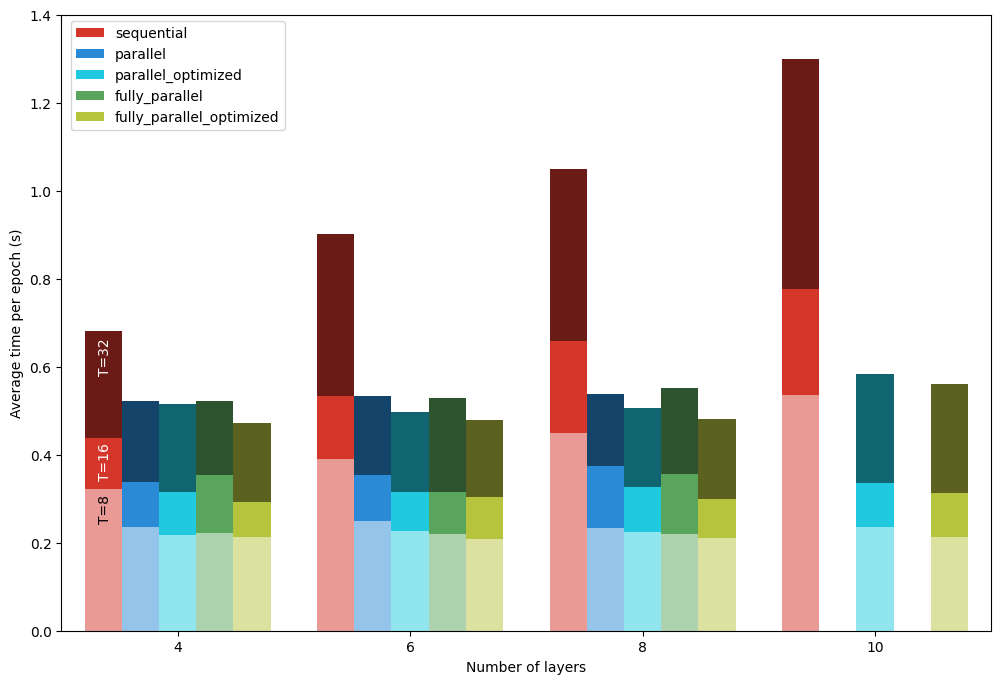

In [47]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for i, (p, t) in enumerate(zip(np.linspace(0.25, 0.75, len(df["T"].unique())), reversed(sorted(df["T"].unique())))):
    sns.barplot(x='layers', y='avg_time', hue='benchmark', data=df[df['T'] == t], ax=ax, palette=generate_palette(base_colors, p))

ax.set_ylim(0, 1.4)
ax.set_ylabel("Average time per epoch (s)")
ax.set_xlabel("Number of layers")
ax.text(0.04, 0.18, "T=8", transform=ax.transAxes, color="black", rotation=90)
ax.text(0.04, 0.25, "T=16", transform=ax.transAxes, color="white", rotation=90)
ax.text(0.04, 0.42, "T=32", transform=ax.transAxes, color="white", rotation=90)
h,l = ax.get_legend_handles_labels()
plt.legend(h[5:10],l[5:10],bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
plt.show()